# Matrix Completion and Recommendation System

In this problem, we will use the 100K MovieLens dataset available at https://grouplens.org/datasets/movielens/100k/ to estimate unknown user ratings given their previous ratings.

Create a copy of this notebook on your personal drive as started code. Download the dataset and upload ``u.data`` under the "Files" tab in the sidebar (**NOTE:** you will need to re-upload this file if you disconnect and delete the current runtime).

In [1]:
import csv
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import torch

/Users/zhengyuzhang/miniconda3/envs/cse446/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's load the 100K MovieLens data.

In [2]:
data = []
with open('u.data') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t')
    for row in spamreader:
        data.append([int(row[0])-1, int(row[1])-1, int(row[2])])
data = np.array(data)

num_observations = len(data)  # num_observations = 100,000
num_users = max(data[:,0])+1  # num_users = 943, indexed 0,...,942
num_items = max(data[:,1])+1  # num_items = 1682 indexed 0,...,1681

np.random.seed(1)
num_train = int(0.8*num_observations)
perm = np.random.permutation(data.shape[0])
train = data[perm[0:num_train],:]
test = data[perm[num_train::],:]

print(f"Successfully loaded 100K MovieLens dataset with",
      f"{len(train)} training samples and {len(test)} test samples")

Successfully loaded 100K MovieLens dataset with 80000 training samples and 20000 test samples


## Part a
Our first estimator pools all users together and, for each movie, outputs as its prediction the average user rating of that movie in ``train``. That is, if $\mu \in \mathbb{R}^m$ is a vector where $\mu_i$ is the average rating of the users that rated the $i$-th movie. Write this estimator $\widehat{R}$ as a rank-one matrix.

Compute the estimate $\widehat{R}$. What is $\mathcal{E}_{\rm test} (\widehat{R})$ for this estimate?

In [3]:
# Your code goes here
# Compute estimate
print(np.max(train[:, 1]))
# Calculate average rating for each movie
movie_ratings_sum = np.zeros(num_items)
movie_ratings_count = np.zeros(num_items)

for user, movie, rating in train:
    movie_ratings_sum[movie] += rating
    movie_ratings_count[movie] += 1

# Avoid division by zero
movie_ratings_count[movie_ratings_count == 0] = 1

average_movie_ratings = movie_ratings_sum / movie_ratings_count

# Construct rank-one matrix R_hat
R_hat = np.tile(average_movie_ratings, (num_users, 1))
# Evaluate test error

test_error = 0
for user, movie, actual_rating in test:
    predicted_rating = R_hat[user, movie]
    test_error += (predicted_rating - actual_rating) ** 2

test_error /= len(test)

print("Test Error (MSE) for the estimator R_hat:", test_error)

1680
Test Error (MSE) for the estimator R_hat: 1.063564200567445


## Part b
Allocate a matrix $\widetilde{R}_{i, j} \in \mathbb{R}^{m \times n}$ and set its entries equal to the known values in the training set, and $0$ otherwise.

Let $\widehat{R}^{(d)}$ be the best rank-$d$ approximation (in terms of squared error) approximation to $\widetilde{R}$. This is equivalent to computing the singular value decomposition (SVD) and using the top $d$ singular values. This learns a lower-dimensional vector representation for users and movies, assuming that each user would give a rating of $0$ to any movie they have not reviewed.

- For each $d = 1, 2, 5, 10, 20, 50$, compute the estimator $\widehat{R}^{(d)}$. We recommend using an efficient solver, such as ``scipy.sparse.linalg.svds``.
- Plot the average squared error of predictions on the training set and test set on a single plot, as a function of $d$.

In [4]:
# Your code goes here
# Create the matrix R twiddle (\widetilde{R}).
R_tilde = np.zeros((num_users, num_items))
for user, movie, rating in train:
    R_tilde[user, movie] = rating

In [5]:
# Your code goes here
def construct_estimator(d, r_twiddle):
    U, s, Vt = svds(r_twiddle, k = d)
    R_hat_d = U @ np.diag(s) @ Vt
    
    return R_hat_d


def get_error(d, r_twiddle, dataset):
    R_hat_d = construct_estimator(d, r_twiddle)
    error = 0
    for user, movie, actual_rating in dataset:
        predicted_rating = R_hat_d[user, movie]
        error += (predicted_rating - actual_rating) ** 2
    return error / len(dataset)

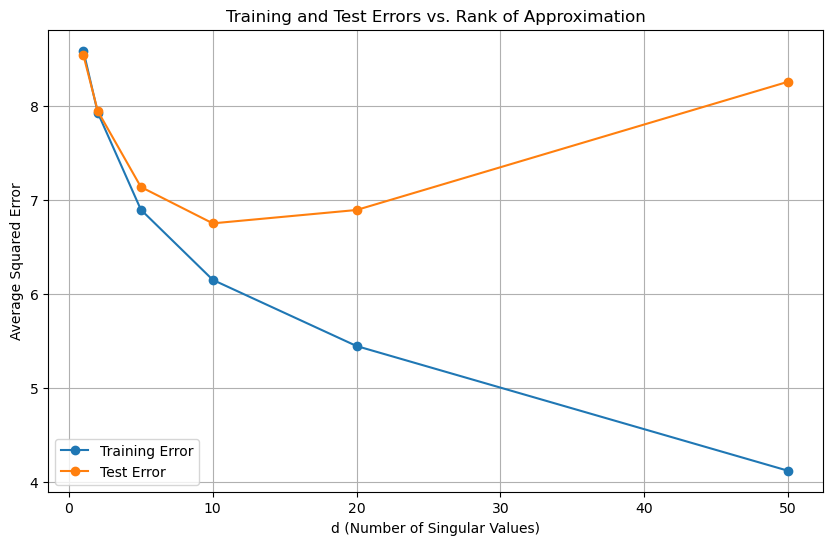

In [6]:
# Your code goes here
# Evaluate train and test error for: d = 1, 2, 5, 10, 20, 50.

d_values = [1, 2, 5, 10, 20, 50]
usv_train_errors = []
usv_test_errors = []
for d in d_values:
    usv_train_error=get_error(d, R_tilde, train)
    usv_test_error=get_error(d, R_tilde, test)
    usv_train_errors.append(usv_train_error)
    usv_test_errors.append(usv_test_error)

# Plot both train and test error as a function of d on the same plot.


plt.figure(figsize=(10, 6))
plt.plot(d_values, usv_train_errors, label='Training Error', marker='o')
plt.plot(d_values, usv_test_errors, label='Test Error', marker='o')
plt.xlabel('d (Number of Singular Values)')
plt.ylabel('Average Squared Error')
plt.title('Training and Test Errors vs. Rank of Approximation')
plt.legend()
plt.grid(True)
plt.show()

## Part c
Replacing all missing values by a constant may impose strong and potentially incorrect assumptions on the unobserved entries of $R$. A more reasonable choice is to minimize the mean squared error (MSE) only on rated movies. Define a loss function:
$$
\mathcal{L} \left( \{u_i\}_{i=1}^m, \{v_j\}_{j=1}^n \right) :=
\sum_{(i, j, R_{i, j}) \in {\rm train}} (\langle u_i,v_j\rangle - R_{i,j})^2 +
\lambda \sum_{i=1}^m \|u_i\|_2^2 +
\lambda \sum_{j=1}^n \|v_j\|_2^2
$$
where $\lambda > 0$ is the regularization coefficient. We will implement algorithms to learn vector representations by minimizing the above loss. You may need to tune $\lambda$ and $\sigma$ to optimize the loss.

Implement alternating minimization (as defined in the homework spec) and plot the MSE of ``train`` and ``test`` for $d \in \{1, 2, 5, 10, 20, 50\}$.

In [30]:
# Your code goes here
def closed_form_u(V, U, l, R_tilde):
  print(V.shape, U.shape)
  for i in range(U.shape[0]):
    R_i_tile = R_tilde[i]
    indices = R_i_tile > 0
    V_j = V[indices, :]
    R_i = R_i_tile[indices]
    A = V_j.T @ V_j + l * np.eye(V_j.shape[1])
    b = (V_j.T @ R_i).reshape(-1, 1)
    U[i,:] = np.linalg.solve(A, b).flatten()
  return U

def closed_form_v(V, U, l, R_tilde):
  for j in range(V.shape[0]):
    R_j_tile = R_tilde[:,j]
    indices = R_j_tile > 0
    U_i = U[indices, :]
    R_j = R_j_tile[indices]
    A = U_i.T @ U_i + l * np.eye(U_i.shape[1])
    b = (U_i.T @ R_j).reshape(-1, 1)
    V[j,:] = np.linalg.solve(A, b).flatten()
  return V


def construct_alternating_estimator(
    d, r_twiddle, l=0.0, delta=1e-2, sigma=0.1, U=None, V=None
):
  old_U, old_V = np.zeros((num_users, d)), np.zeros((num_items, d))
  if U is None:
    U = np.random.rand(num_users, d) * sigma
  if V is None:
    V = np.random.rand(num_items, d) * sigma
  while (np.max(np.abs(V - old_V)) > delta and np.max(np.abs(U - old_U)) > delta):
    old_U, old_V = U, V
    U = closed_form_u(V, U, l, r_twiddle)
    V = closed_form_v(V, U, l, r_twiddle)
  return U, V

In [31]:
def calc_uv_error(dataset, U, V):
    user = dataset[:,0]
    item = dataset[:,1]
    score = dataset[:,2]
    # print(U.shape, V.shape)
    pred = np.einsum('ij,ij->i', U[user], V[item])
    mse_error = np.mean((score-pred) ** 2)
    return mse_error
    

(1682, 1) (943, 1)
(1682, 2) (943, 2)
(1682, 5) (943, 5)
(1682, 10) (943, 10)
(1682, 20) (943, 20)
(1682, 50) (943, 50)
(1682, 1) (943, 1)
(1682, 2) (943, 2)
(1682, 5) (943, 5)
(1682, 10) (943, 10)
(1682, 20) (943, 20)
(1682, 50) (943, 50)
(1682, 1) (943, 1)
(1682, 2) (943, 2)
(1682, 5) (943, 5)
(1682, 10) (943, 10)
(1682, 20) (943, 20)
(1682, 50) (943, 50)
(1682, 1) (943, 1)
(1682, 2) (943, 2)
(1682, 5) (943, 5)
(1682, 10) (943, 10)
(1682, 20) (943, 20)
(1682, 50) (943, 50)
(1682, 1) (943, 1)
(1682, 2) (943, 2)
(1682, 5) (943, 5)
(1682, 10) (943, 10)
(1682, 20) (943, 20)
(1682, 50) (943, 50)
(1682, 1) (943, 1)
(1682, 2) (943, 2)
(1682, 5) (943, 5)
(1682, 10) (943, 10)
(1682, 20) (943, 20)
(1682, 50) (943, 50)
(1682, 1) (943, 1)
(1682, 2) (943, 2)
(1682, 5) (943, 5)
(1682, 10) (943, 10)
(1682, 20) (943, 20)
(1682, 50) (943, 50)
(1682, 1) (943, 1)
(1682, 2) (943, 2)
(1682, 5) (943, 5)
(1682, 10) (943, 10)
(1682, 20) (943, 20)
(1682, 50) (943, 50)
(1682, 1) (943, 1)
(1682, 2) (943, 2)
(1

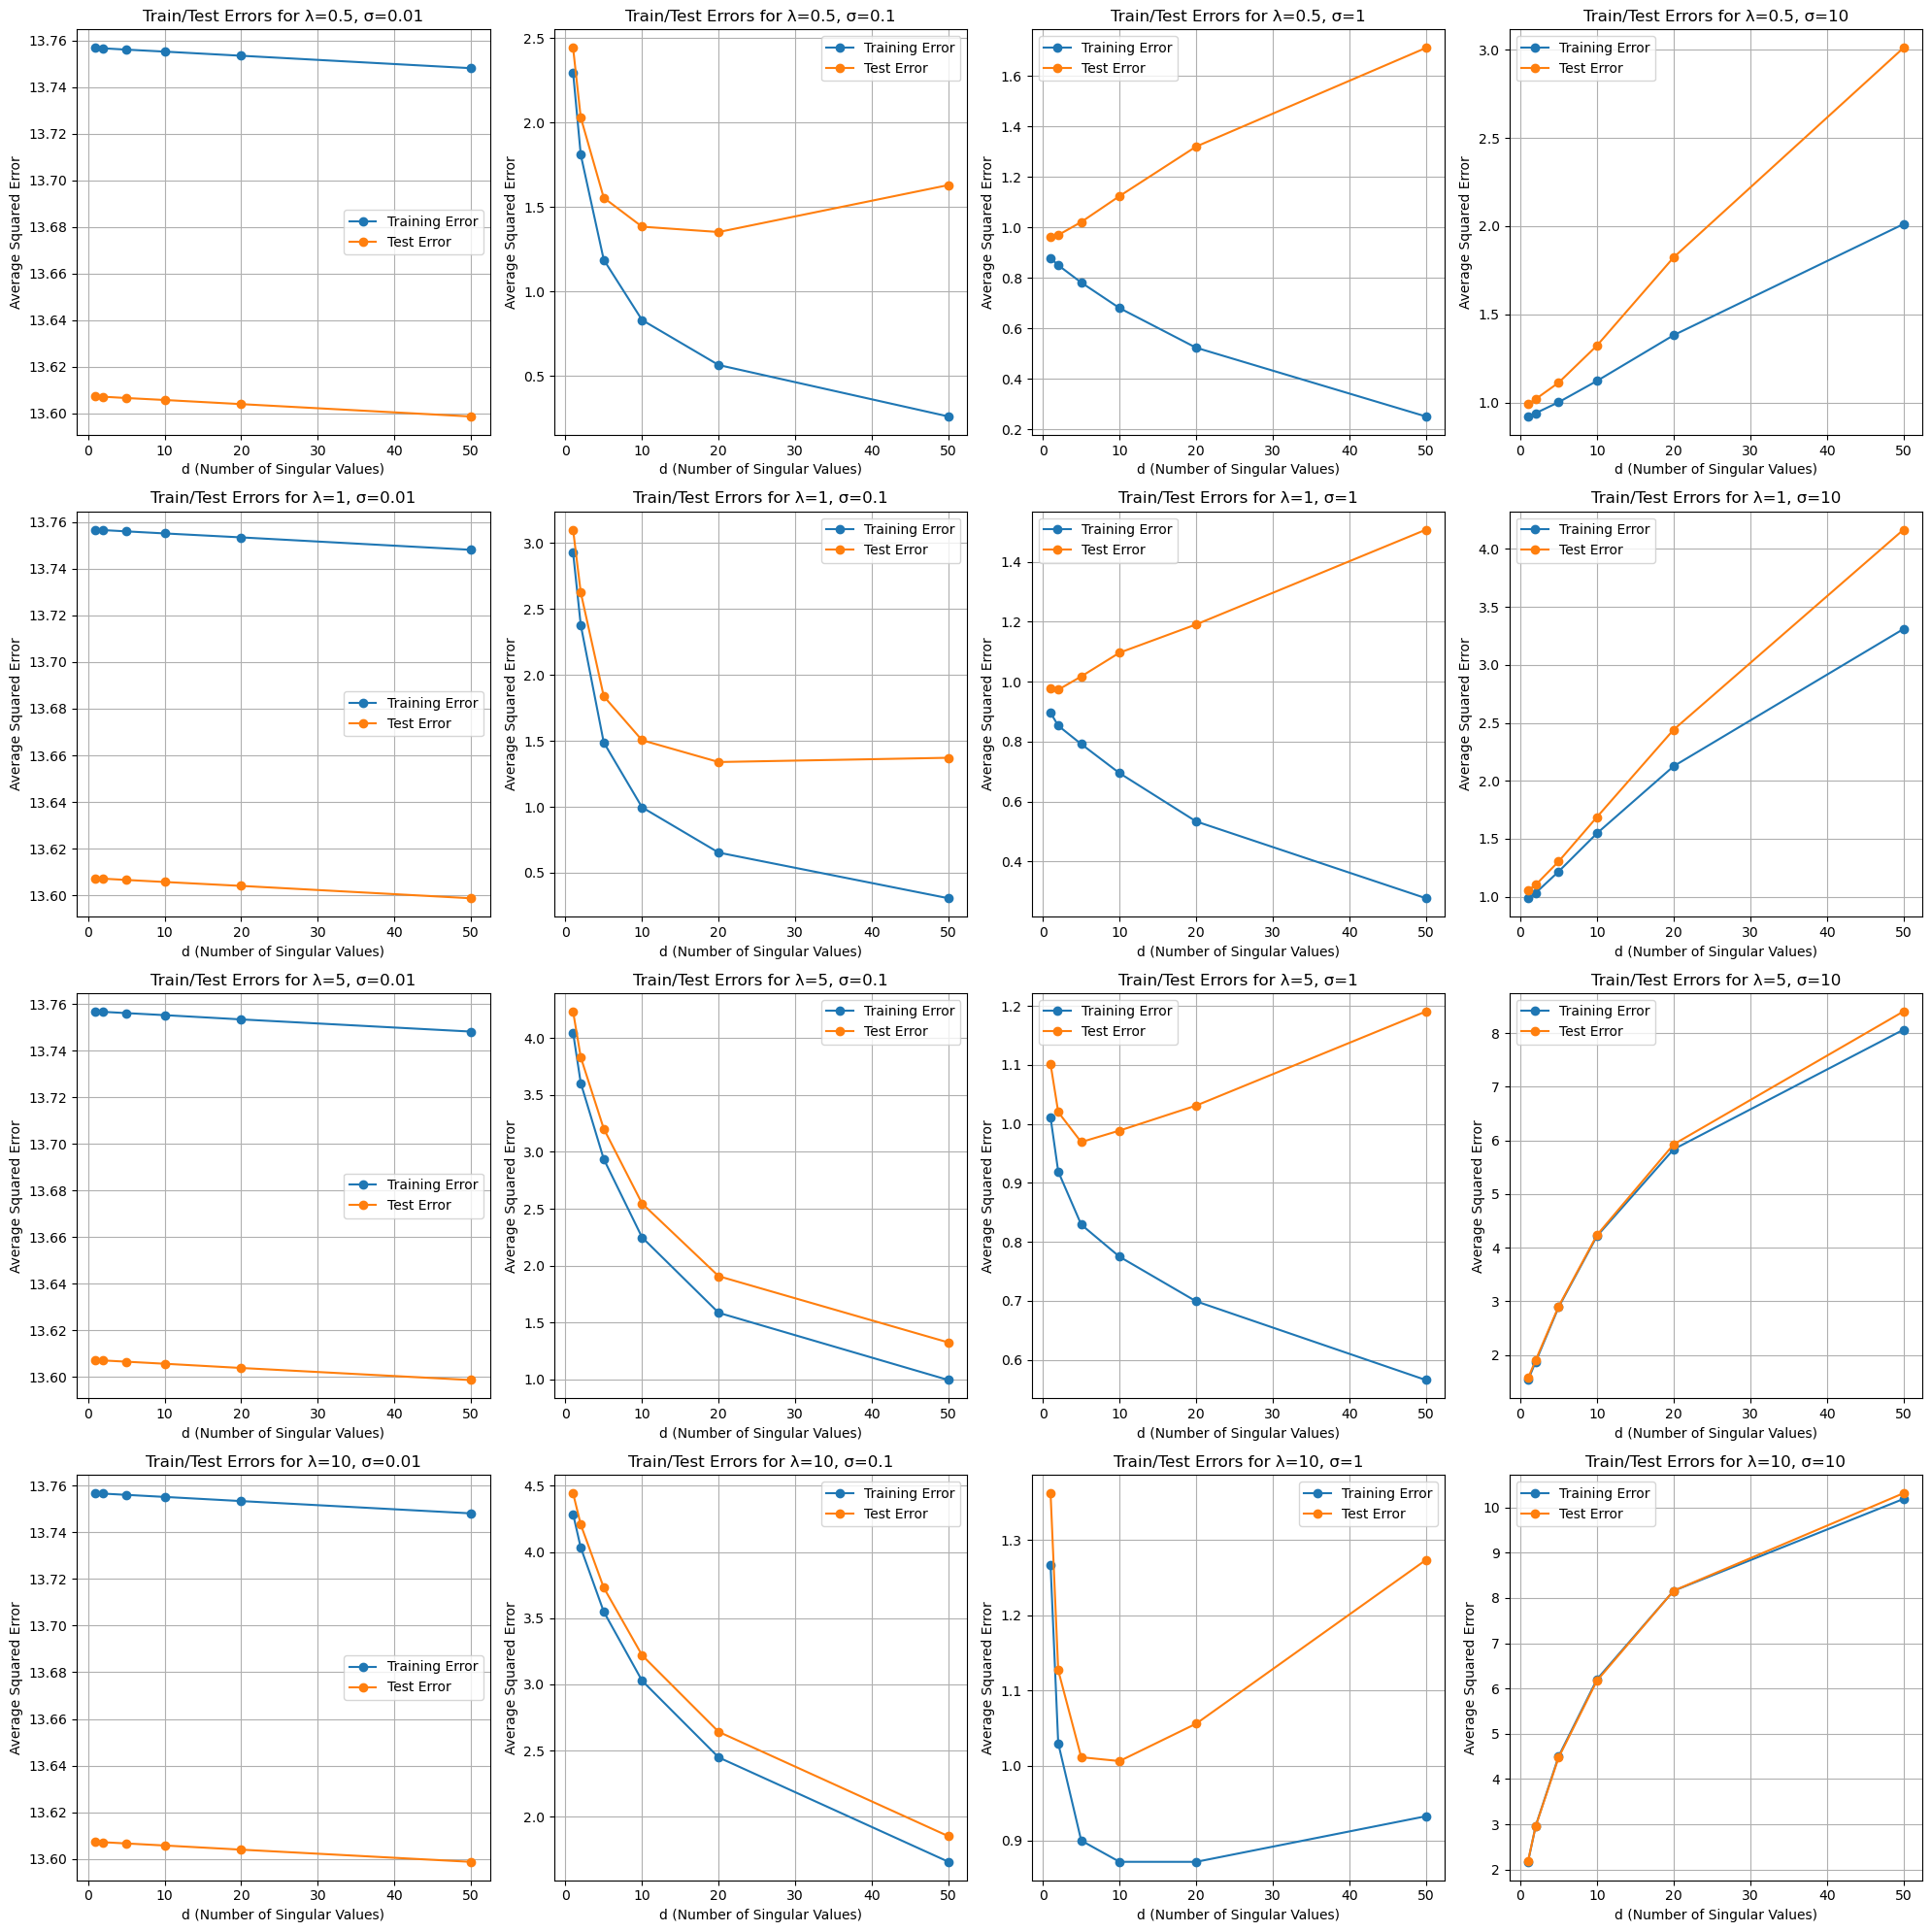

In [37]:
from itertools import product
d_vals = [1, 2, 5, 10, 20, 50]
lambdas = [0.5, 1, 5, 10]
sigmas = [0.01, 0.1, 1, 10]

# Prepare the plots
fig, axes = plt.subplots(4, 4, figsize=(20, 20)) # 4x4 grid for 16 combinations
axes = axes.flatten()

# Iterate over all combinations of lambdas and sigmas
for index, (lambda_val, sigma_val) in enumerate(product(lambdas, sigmas)):
    uv_train_errors = []
    uv_test_errors = []

    for d in d_vals:
        U, V = construct_alternating_estimator(d=d, r_twiddle=R_tilde, l=lambda_val, sigma=sigma_val)
        uv_train_errors.append(calc_uv_error(train, U, V))
        uv_test_errors.append(calc_uv_error(test, U, V))

    # Plot the train and test error for each combination
    ax = axes[index]
    ax.plot(d_vals, uv_train_errors, label='Training Error', marker='o')
    ax.plot(d_vals, uv_test_errors, label='Test Error', marker='o')
    ax.set_xlabel('d (Number of Singular Values)')
    ax.set_ylabel('Average Squared Error')
    ax.set_title(f'Train/Test Errors for λ={lambda_val}, σ={sigma_val}')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()